# Exploring the Moon with Machine Learning

<a href="https://drive.google.com/uc?export=view&id=1hCl8j1aP_9D5KBu943BH7hDfNXt6U8a5"><img src="https://drive.google.com/uc?export=view&id=1hCl8j1aP_9D5KBu943BH7hDfNXt6U8a5" style="width: 650px; max-width: 100%; height: auto" title="Click to enlarge picture" />

# Chemical Composition Map


<a href="https://drive.google.com/uc?export=view&id=1OaA9PJ5IZN797-DwgaXYKlvY9dO8i0nK"><img src="https://drive.google.com/uc?export=view&id=1OaA9PJ5IZN797-DwgaXYKlvY9dO8i0nK" style="width: 650px; max-width: 100%; height: auto" title="Click to enlarge picture" />


### The chemical composition of lunar rocks determines how light or dark the surface is. Note the relationship between Element A and dark regions on the Moon in the above maps. 

### Machine learning can discover the relationship between the visible appearance of the Moon (its albedo) and its chemical composition. 

### Your task is to predict the elements A, B, C, and D using the lunar albedo map and other elements. We have withheld a region by setting all values to zero. DO NOT TRAIN OR TEST ON THIS. Your score will be measured using the combined mean-squared error of all element maps. You may use different models for each element, or you can submit a single model.

# Start Coding

### Import necessary libraries (you may use whatever you want)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pickle
import xgboost as xgb
np.random.seed(123)

%matplotlib inline

### Load data

#### The data consists of the lunar albedo map and four element maps

It can be found at https://drive.google.com/drive/folders/1zwBGJdwG0Lk2MNAeWMypxebWfqt4btsx?usp=sharing

In [2]:
# Where the data is
data_path = '/content/'

# Names of the files
albedo_file    = data_path + 'Albedo.csv'
element_A_file = data_path + 'Element_A_Map.csv'
element_B_file = data_path + 'Element_B_Map.csv'
element_C_file = data_path + 'Element_C_Map.csv'
element_D_file = data_path + 'Element_D_Map.csv'


In [3]:
albedo_data = pd.read_csv(albedo_file, sep=',',header=None)
albedo_data = albedo_data.values

element_A_data = pd.read_csv(element_A_file, sep=',',header=None)
element_A_data = element_A_data.values

element_B_data = pd.read_csv(element_B_file, sep=',',header=None)
element_B_data = element_B_data.values

element_C_data = pd.read_csv(element_C_file, sep=',',header=None)
element_C_data = element_C_data.values

element_D_data = pd.read_csv(element_D_file, sep=',',header=None)
element_D_data = element_D_data.values

In [4]:
data_shape = albedo_data.shape

In [5]:
masked_rows, masked_columns = np.where(albedo_data == 0)
twoD_mask = albedo_data == 0

### Plot Data

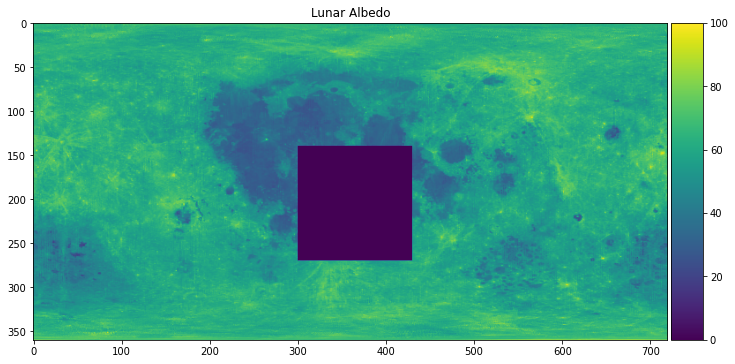

In [6]:
# Albedo
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 9))

im = ax.imshow(albedo_data, vmax=100, vmin=0)
ax.set_title('Lunar Albedo')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

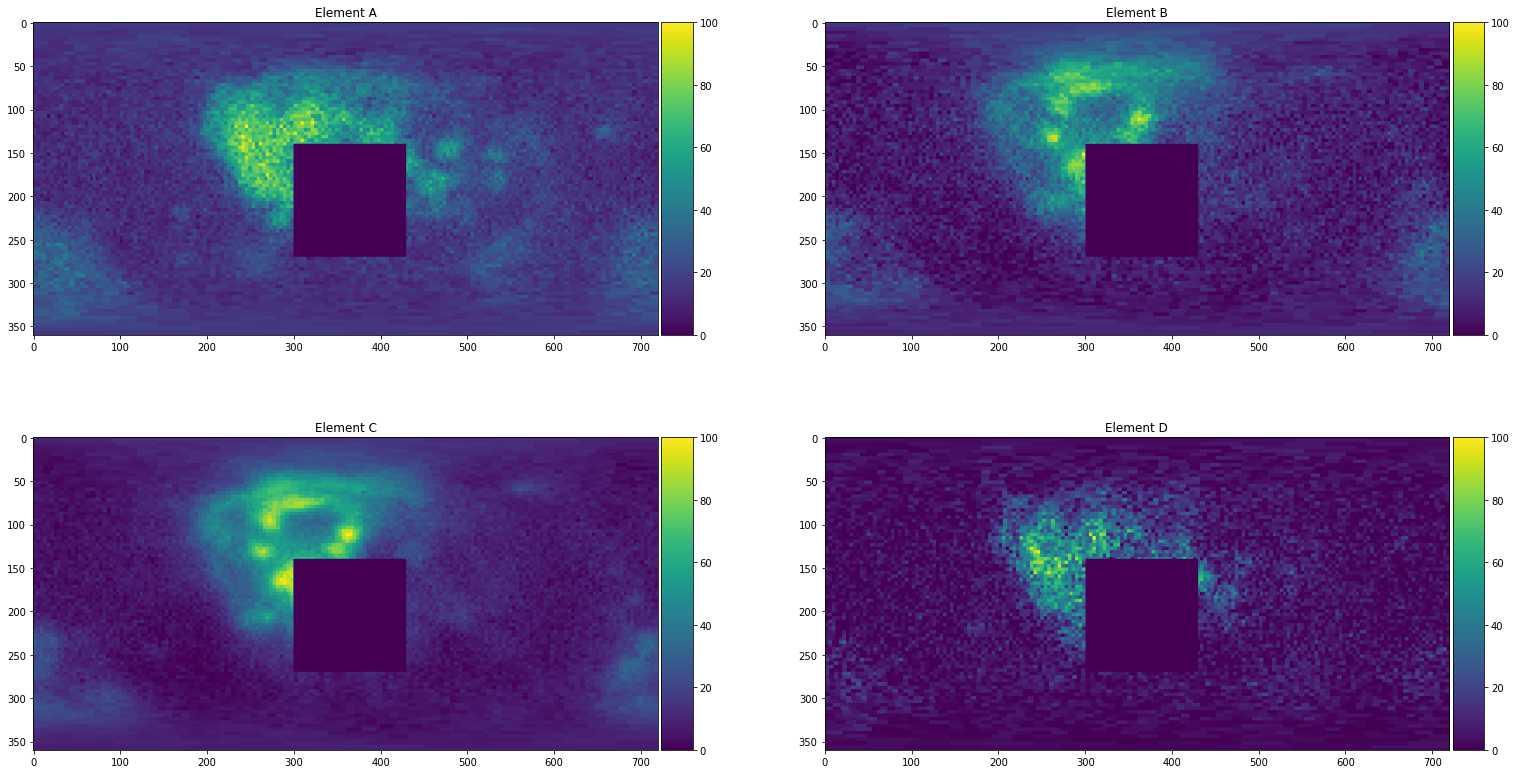

In [7]:
# Elements
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(element_A_data, vmax=100, vmin=0)
axs[0, 0].set_title('Element A')
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(element_B_data, vmax=100, vmin=0)
axs[0, 1].set_title('Element B')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(element_C_data, vmax=100, vmin=0)
axs[1, 0].set_title('Element C')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(element_D_data, vmax=100, vmin=0)
axs[1, 1].set_title('Element D')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [8]:
# Flatten the data
albedo    = albedo_data.flatten()
element_A = element_A_data.flatten()
element_B = element_B_data.flatten()
element_C = element_C_data.flatten()
element_D = element_D_data.flatten()

flat_unmasked_indices = np.where(albedo > 0)
flat_masked_indices   = np.where(albedo == 0)
flat_mask = albedo == 0

### Split data into training and testing sets

In [9]:
# Fraction of data that's used for training
train_split = 0.8

In [10]:
# Get indices for each set (lets us reconstruct the map)
train_indices = np.random.choice([i for i in range(len(albedo))], 
                                  int(train_split*len(albedo)), 
                                  replace=False)

test_indices = np.delete([i for i in range(len(albedo))], train_indices)

albedo_train = albedo[train_indices]
albedo_test  = albedo[test_indices]

element_A_train = element_A[train_indices]
element_A_test  = element_A[test_indices]

element_B_train = element_B[train_indices]
element_B_test  = element_B[test_indices]

element_C_train = element_C[train_indices]
element_C_test  = element_C[test_indices]

element_D_train = element_D[train_indices]
element_D_test  = element_D[test_indices]

unmasked_train_indices = np.where(albedo_train > 0)
unmasked_test_indices  = np.where(albedo_test > 0)
masked_train_indices   = np.where(albedo_train == 0)
masked_test_indices    = np.where(albedo_test == 0)

### Plot train set

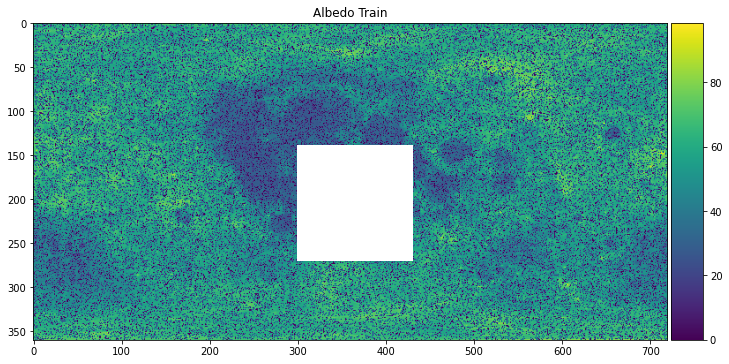

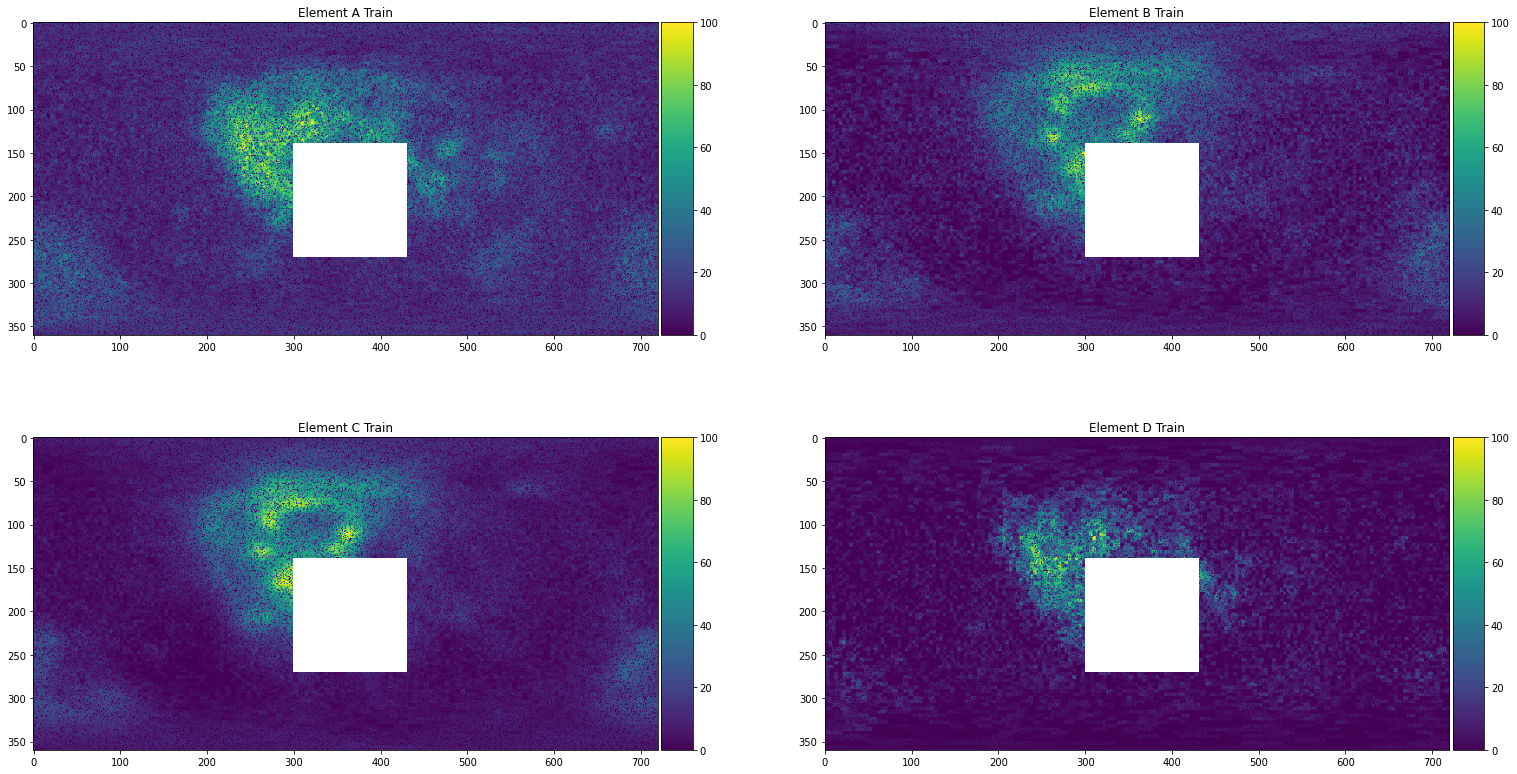

In [11]:
this_albedo    = albedo.copy()
this_element_A = element_A.copy()
this_element_B = element_B.copy()
this_element_C = element_C.copy()
this_element_D = element_D.copy()

# Make all non-train data -1
this_albedo[test_indices]    = -1
this_element_A[test_indices] = -1
this_element_B[test_indices] = -1
this_element_C[test_indices] = -1
this_element_D[test_indices] = -1

# Mask withheld region
this_albedo    = np.ma.MaskedArray(this_albedo, flat_mask)
this_element_A = np.ma.MaskedArray(this_element_A, flat_mask)
this_element_B = np.ma.MaskedArray(this_element_B, flat_mask)
this_element_C = np.ma.MaskedArray(this_element_C, flat_mask)
this_element_D = np.ma.MaskedArray(this_element_D, flat_mask)

this_albedo    = this_albedo.reshape(data_shape)
this_element_A = this_element_A.reshape(data_shape)
this_element_B = this_element_B.reshape(data_shape)
this_element_C = this_element_C.reshape(data_shape)
this_element_D = this_element_D.reshape(data_shape)

# Plot albedo
fig, ax = plt.subplots(figsize=(12, 9))

im = ax.imshow(this_albedo, vmin=0)
ax.set_title('Albedo Train')
# Set Colorbars
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

# Plot elements
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(this_element_A, vmin=0, vmax=100)
axs[0, 0].set_title('Element A Train')
# Set Colorbars
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(this_element_B, vmin=0, vmax=100)
axs[0, 1].set_title('Element B Train')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(this_element_C, vmin=0, vmax=100)
axs[1, 0].set_title('Element C Train')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(this_element_D, vmin=0, vmax=100)
axs[1, 1].set_title('Element D Train')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

### Plot test set

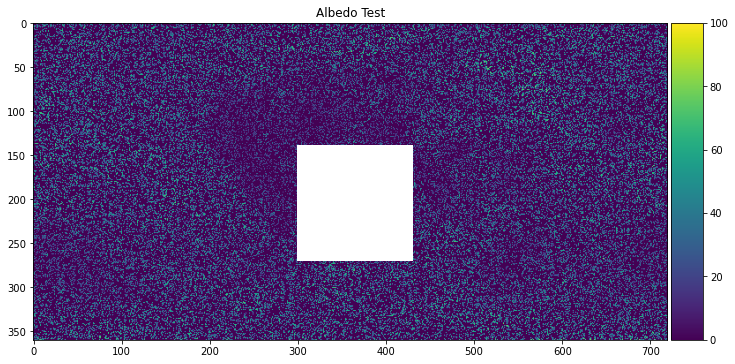

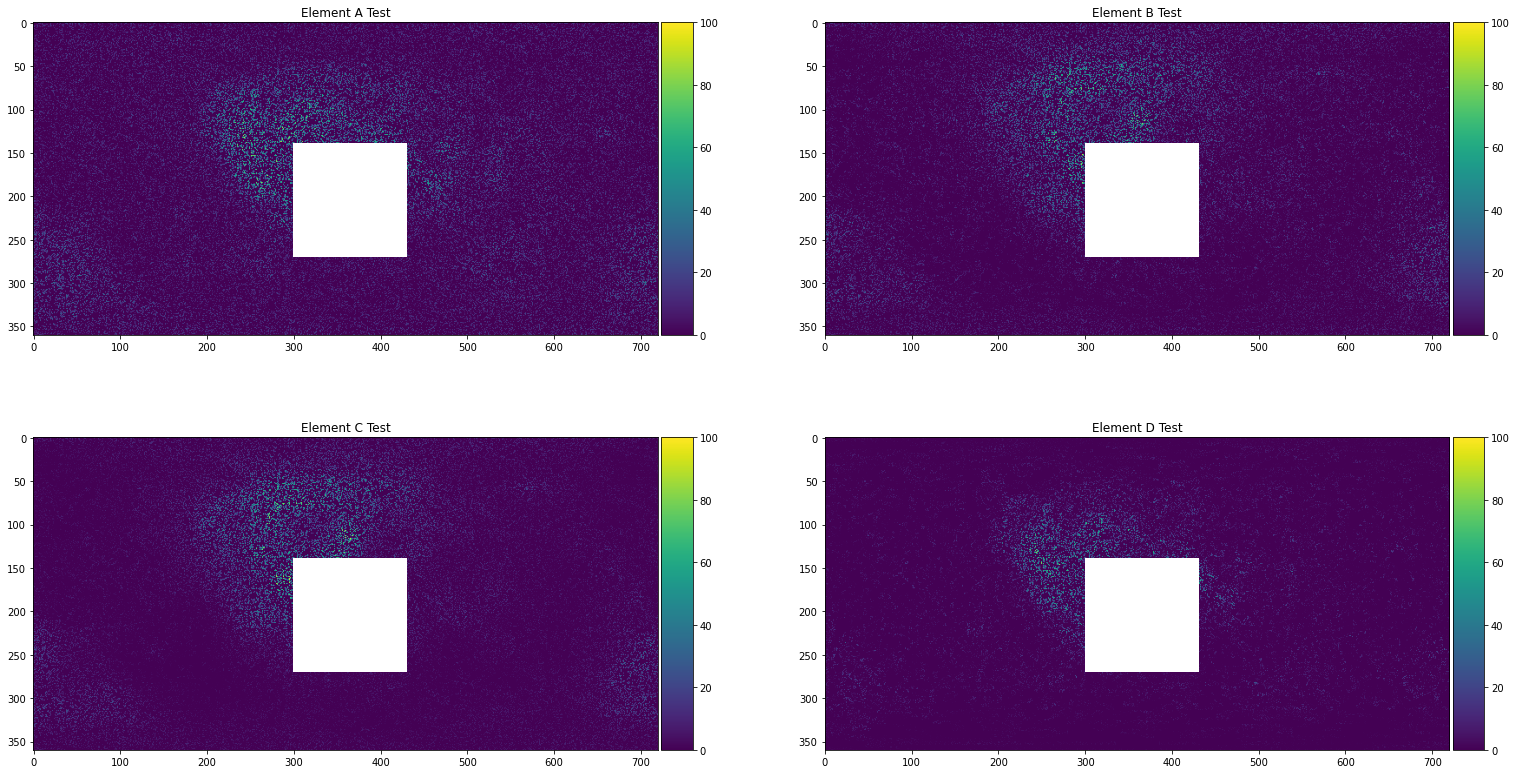

In [12]:
this_albedo = albedo.copy()
this_element_A = element_A.copy()
this_element_B = element_B.copy()
this_element_C = element_C.copy()
this_element_D = element_D.copy()

# Make all non-test data -1
this_albedo[train_indices] = -1
this_element_A[train_indices] = -1
this_element_B[train_indices] = -1
this_element_C[train_indices] = -1
this_element_D[train_indices] = -1

# Mask withheld region
this_albedo = np.ma.MaskedArray(this_albedo, flat_mask)
this_element_A = np.ma.MaskedArray(this_element_A, flat_mask)
this_element_B = np.ma.MaskedArray(this_element_B, flat_mask)
this_element_C = np.ma.MaskedArray(this_element_C, flat_mask)
this_element_D = np.ma.MaskedArray(this_element_D, flat_mask)

this_albedo = this_albedo.reshape(data_shape)
this_element_A = this_element_A.reshape(data_shape)
this_element_B = this_element_B.reshape(data_shape)
this_element_C = this_element_C.reshape(data_shape)
this_element_D = this_element_D.reshape(data_shape)

# Plot albedo
fig, ax = plt.subplots(figsize=(12, 9))

im = ax.imshow(this_albedo, vmin=0, vmax=100)
ax.set_title('Albedo Test')
# Set Colorbars
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

# Plot elements
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(this_element_A, vmin=0, vmax=100)
axs[0, 0].set_title('Element A Test')
# Set Colorbars
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(this_element_B, vmin=0, vmax=100)
axs[0, 1].set_title('Element B Test')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(this_element_C, vmin=0, vmax=100)
axs[1, 0].set_title('Element C Test')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(this_element_D, vmin=0, vmax=100)
axs[1, 1].set_title('Element D Test')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

### Finish modifying data

In [13]:
# # Get rid of masked region
albedo_train = albedo_train[unmasked_train_indices]
element_A_train = element_A_train[unmasked_train_indices]
element_B_train = element_B_train[unmasked_train_indices]
element_C_train = element_C_train[unmasked_train_indices]
element_D_train = element_D_train[unmasked_train_indices]

In [14]:
# Sklearn requires that each entry be its own array
albedo_train = albedo_train.reshape(len(albedo_train), 1)
element_A_train = element_A_train.reshape(len(element_A_train), 1)
element_B_train = element_B_train.reshape(len(element_B_train), 1)
element_C_train = element_C_train.reshape(len(element_C_train), 1)
element_D_train = element_D_train.reshape(len(element_D_train), 1)

albedo_test = albedo_test.reshape(len(albedo_test), 1)
element_A_test = element_A_test.reshape(len(element_A_test), 1)
element_B_test = element_B_test.reshape(len(element_B_test), 1)
element_C_test = element_C_test.reshape(len(element_C_test), 1)
element_D_test = element_D_test.reshape(len(element_D_test), 1)

# Make models
## This is an example solution using a tuned XGB Regression model.

We are tuning 3 basic parameters, max_depth, learning_rate, n_estimators for all the models.

## Train

## **Element_A**

In [ ]:
params = { 'max_depth': [1,2,3],'learning_rate' : [0.06,0.07,0.08],'n_estimators' : [105,110,115]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         verbose=1)

clf.fit(albedo_train,element_A_train)
print("Best parameters:", clf.best_params_)
print("Lowest MSE: ", (-clf.best_score_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[18:42:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  8.6min finished


[18:51:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 110}
Lowest MSE:  45.42928049762384


**Best parameters:** 
- learning_rate: 0.07, 
- max_depth: 2, 
- n_estimators: 110
<br>

**Lowest MSE:  45.42928049762384**
---



### **Element_B**

In [ ]:
params = { 'max_depth': [1,2,3],'learning_rate' : [0.06,0.07,0.08],'n_estimators' : [110,115,120]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         verbose=1)

clf.fit(albedo_train,element_B_train)
print("Best parameters:", clf.best_params_)
print("Lowest MSE: ", (-clf.best_score_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[18:52:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:52:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:53:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:53:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:53:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:53:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:53:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  8.9min finished


[19:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 110}
Lowest MSE:  135.25622565577774


In [ ]:
params = { 'max_depth': [2],'learning_rate' : [0.08,0.09,0.10],'n_estimators' : [100,105,110]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         verbose=1)

clf.fit(albedo_train,element_B_train)
print("Best parameters:", clf.best_params_)
print("Lowest MSE: ", (-clf.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[19:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[19:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.7min finished


[19:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 105}
Lowest MSE:  135.25617591583753


**Best parameters:**
- learning_rate: 0.08,
- max_depth: 2,
- n_estimators: 105
<br>

## **Lowest MSE:  135.25617591583753**

## **Element_C**

In [ ]:
params = { 'max_depth': [1,2,3],'learning_rate' : [0.07,0.08,0.09],'n_estimators' : [105,110,115]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         verbose=1)

clf.fit(albedo_train,element_C_train)
print("Best parameters:", clf.best_params_)
print("Lowest MSE: ", (-clf.best_score_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[19:11:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[19:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:11:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:11:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:11:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:11:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:11:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:11:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  8.6min finished


[19:20:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 115}
Lowest MSE:  139.09531461078538


In [ ]:
params = { 'max_depth': [2],'learning_rate' : [0.06],'n_estimators' : [128,130,132,135]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         verbose=1)

clf.fit(albedo_train,element_C_train)
print("Best parameters:", clf.best_params_)
print("Lowest MSE: ", (-clf.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[19:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[19:30:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.5min finished


[19:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'learning_rate': 0.06, 'max_depth': 2, 'n_estimators': 132}
Lowest MSE:  139.0882370056805


**Best parameters:**
- learning_rate: 0.06
- max_depth: 2, 
- n_estimators: 132
<br>

##**Lowest MSE:  139.0882370056805**



### **Element_D**

In [ ]:
params = { 'max_depth': [1,2,3],'learning_rate' : [0.07,0.08,0.09],'n_estimators' : [105,110,115]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         verbose=1)

clf.fit(albedo_train,element_D_train)
print("Best parameters:", clf.best_params_)
print("Lowest MSE: ", (-clf.best_score_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[19:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[19:33:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  8.5min finished


[19:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 105}
Lowest MSE:  49.06574945477043


In [ ]:
params = { 'max_depth': [2],'learning_rate' : [0.05,0.06,0.07],'n_estimators' : [100,102,105,107]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_mean_squared_error',
                         verbose=1)

clf.fit(albedo_train,element_D_train)
print("Best parameters:", clf.best_params_)
print("Lowest MSE: ", (-clf.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[19:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[19:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.6min finished


[19:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'learning_rate': 0.06, 'max_depth': 2, 'n_estimators': 105}
Lowest MSE:  49.06533538933609


Best parameters
- learning_rate: 0.06,
- max_depth: 2,
- n_estimators: 105
<br>

## **Lowest MSE:  49.06533538933609**

In [15]:
#Final model making with the specific hyperparameters

element_A_model = xgb.XGBRegressor(seed = 20,learning_rate = 0.07, max_depth = 2, n_estimators = 110)
element_B_model = xgb.XGBRegressor(seed = 20,learning_rate = 0.08, max_depth = 2, n_estimators = 105)
element_C_model = xgb.XGBRegressor(seed = 20,learning_rate = 0.06, max_depth = 2, n_estimators = 132)
element_D_model = xgb.XGBRegressor(seed = 20,learning_rate = 0.06, max_depth = 2, n_estimators = 105)

element_A_model.fit(albedo_train, element_A_train)
element_B_model.fit(albedo_train, element_B_train)
element_C_model.fit(albedo_train, element_C_train)
element_D_model.fit(albedo_train, element_D_train)
print('Fit models')

[04:10:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:11:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fit models


## Predict

In [16]:
element_A_pred = element_A_model.predict(albedo_test)
element_B_pred = element_B_model.predict(albedo_test)
element_C_pred = element_C_model.predict(albedo_test)
element_D_pred = element_D_model.predict(albedo_test)

## Score

In [17]:
# Only score using unmasked regions
element_A_mse = mean_squared_error(element_A_test[unmasked_test_indices], element_A_pred[unmasked_test_indices])
element_B_mse = mean_squared_error(element_B_test[unmasked_test_indices], element_B_pred[unmasked_test_indices])
element_C_mse = mean_squared_error(element_C_test[unmasked_test_indices], element_C_pred[unmasked_test_indices])
element_D_mse = mean_squared_error(element_D_test[unmasked_test_indices], element_D_pred[unmasked_test_indices])

In [18]:
print ("Element A MSE = ",element_A_mse)
print ("Element B MSE = ",element_B_mse)
print ("Element c MSE = ",element_C_mse)
print ("Element D MSE = ",element_D_mse)

Element A MSE =  44.77168687185551
Element B MSE =  132.72865438133198
Element c MSE =  136.14110824043658
Element D MSE =  47.963165051933174


In [19]:
score = element_A_mse + element_B_mse + element_C_mse + element_D_mse
print('Sum of mean-squared errors = %.5f' % (score))

Sum of mean-squared errors = 361.60461


# Deliverables

* Google Colab Jupyter Notebook showing your solution along with the final model score More details regarding the format of the notebook can be found in the sample Google Colab notebook provided for this challenge.  
* A txt file for each element containing your predictions on the test data. Format should be: x_coordinate, y_coordinate, predicted_value. Put name of element in file. An example is provided.
* The final trained model including the model architecture and the trained weights (For example: HDF5 file, .pb file, .pt, .sav file, etc.). You are free to choose Machine Learning Framework of your choice.
* Example submissions can be found https://drive.google.com/drive/folders/1EsqNLc5DzCsaJuvSTYF85gMS5PTVell4?usp=sharing

## Save models
Other formats can be used

In [20]:
pickle.dump(element_A_model, open('./element_A_model.sav', 'wb'))
pickle.dump(element_B_model, open('./element_B_model.sav', 'wb'))
pickle.dump(element_C_model, open('./element_C_model.sav', 'wb'))
pickle.dump(element_D_model, open('./element_D_model.sav', 'wb'))

## Save results

In [21]:
# Map that only looks at test data (train pixels = -1e6 to ensure no overlap with predictions)
reconstructed_A_predictions = np.zeros(len(element_B)) - 1e6
reconstructed_B_predictions = np.zeros(len(element_B)) - 1e6
reconstructed_C_predictions = np.zeros(len(element_B)) - 1e6
reconstructed_D_predictions = np.zeros(len(element_B)) - 1e6

# Fill in predicted values
for (i, index) in enumerate(test_indices):
    reconstructed_A_predictions[index] = element_A_pred[i]
    reconstructed_B_predictions[index] = element_B_pred[i]
    reconstructed_C_predictions[index] = element_C_pred[i]
    reconstructed_D_predictions[index] = element_D_pred[i]
        
# Reshape into images
reconstructed_A_predictions = reconstructed_A_predictions.reshape(data_shape)
reconstructed_B_predictions = reconstructed_B_predictions.reshape(data_shape)
reconstructed_C_predictions = reconstructed_C_predictions.reshape(data_shape)
reconstructed_D_predictions = reconstructed_D_predictions.reshape(data_shape)

# Get coordinates of pixel
xs, ys = [], []
A_values, B_values, C_values, D_values = [], [], [], []

for i in range(len(reconstructed_A_predictions)):
    for j in range(len(reconstructed_A_predictions[i])):
        if reconstructed_A_predictions[i][j] == -1e6:
            continue
        xs.append(i)
        ys.append(j)
        A_values.append(reconstructed_A_predictions[i][j])
        B_values.append(reconstructed_B_predictions[i][j])
        C_values.append(reconstructed_C_predictions[i][j])
        D_values.append(reconstructed_D_predictions[i][j])

        
# Save
with open('./element_A1_predictions.txt', 'w') as f:
    for i in range(len(xs)):
        this_str = '%i, %i, %f \n' % (xs[i], ys[i], A_values[i])
        f.write(this_str)
        
with open('./element_B1_predictions.txt', 'w') as f:
    for i in range(len(xs)):
        this_str = '%i, %i, %f \n' % (xs[i], ys[i], A_values[i])
        f.write(this_str)
        
with open('./element_C1_predictions.txt', 'w') as f:
    for i in range(len(xs)):
        this_str = '%i, %i, %f \n' % (xs[i], ys[i], A_values[i])
        f.write(this_str)
        
with open('./element_D1_predictions.txt', 'w') as f:
    for i in range(len(xs)):
        this_str = '%i, %i, %f \n' % (xs[i], ys[i], A_values[i])
        f.write(this_str)


# Optional Diagnostic Plots

### Reconstruct map using predictions

In [22]:
# Entire map
reconstructed_element_A = element_A.copy()
reconstructed_element_B = element_B.copy()
reconstructed_element_C = element_C.copy()
reconstructed_element_D = element_D.copy()

for (i, index) in enumerate(test_indices):
    
    # If the predicted pixel is unmasked, put it in the new map
    if index in flat_unmasked_indices[0]:
        reconstructed_element_A[index] = element_A_pred[i]
        reconstructed_element_B[index] = element_B_pred[i]
        reconstructed_element_C[index] = element_C_pred[i]
        reconstructed_element_D[index] = element_D_pred[i]

    else:
        reconstructed_element_A[index] = 0
        reconstructed_element_B[index] = 0
        reconstructed_element_C[index] = 0
        reconstructed_element_D[index] = 0 
        
# Make withheld region
reconstructed_element_A = np.ma.MaskedArray(reconstructed_element_A, flat_mask)
reconstructed_element_B = np.ma.MaskedArray(reconstructed_element_B, flat_mask)
reconstructed_element_C = np.ma.MaskedArray(reconstructed_element_C, flat_mask)
reconstructed_element_D = np.ma.MaskedArray(reconstructed_element_D, flat_mask)

# Reshape into image
reconstructed_element_A = reconstructed_element_A.reshape(data_shape)
reconstructed_element_B = reconstructed_element_B.reshape(data_shape)
reconstructed_element_C = reconstructed_element_C.reshape(data_shape)
reconstructed_element_D = reconstructed_element_D.reshape(data_shape)

### Plot reconstructed map (including training data)

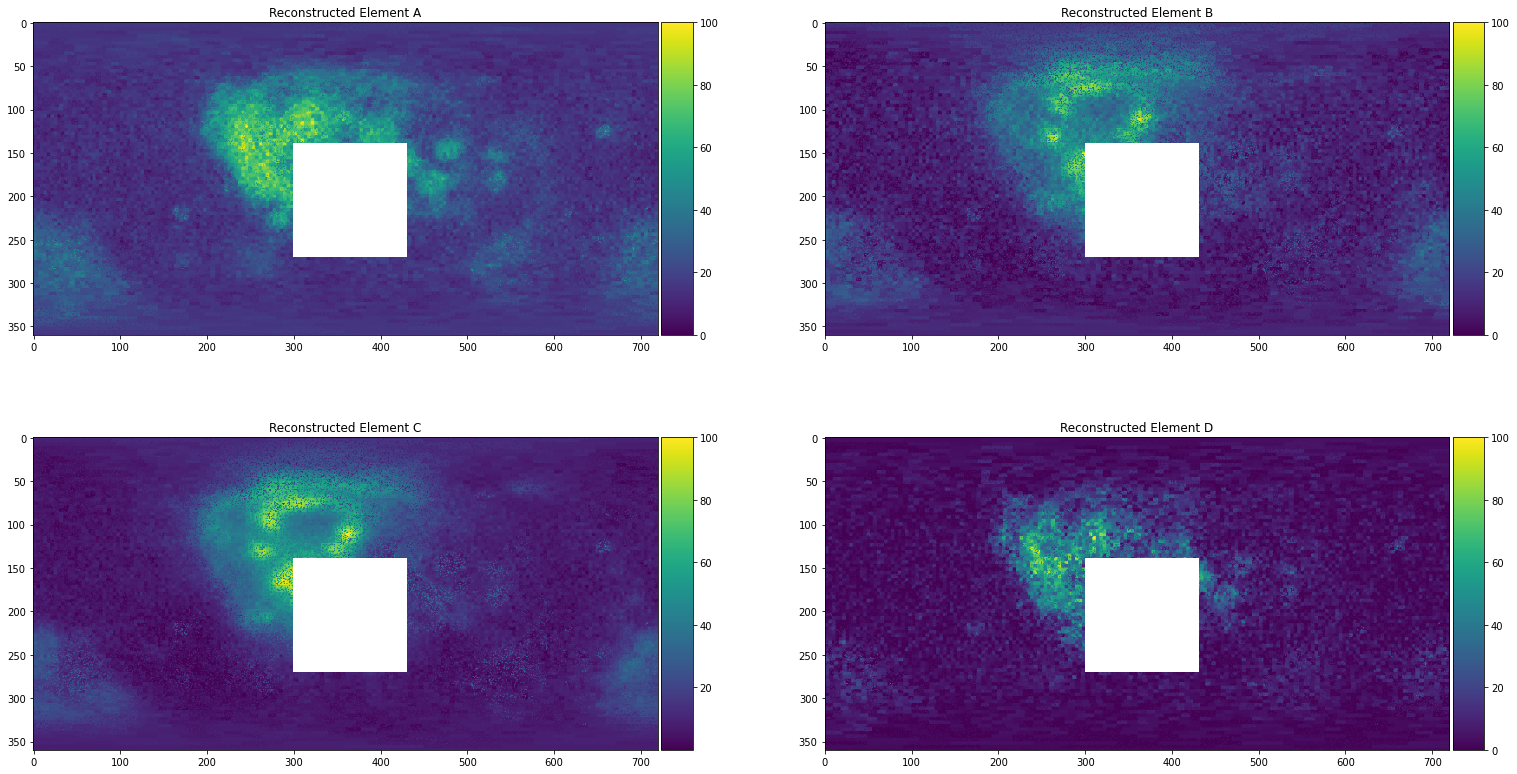

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(reconstructed_element_A)
axs[0, 0].set_title('Reconstructed Element A')
# Set Colorbars
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(reconstructed_element_B)
axs[0, 1].set_title('Reconstructed Element B')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(reconstructed_element_C)
axs[1, 0].set_title('Reconstructed Element C')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(reconstructed_element_D)
axs[1, 1].set_title('Reconstructed Element D')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

### Plot difference between predicted and actual maps

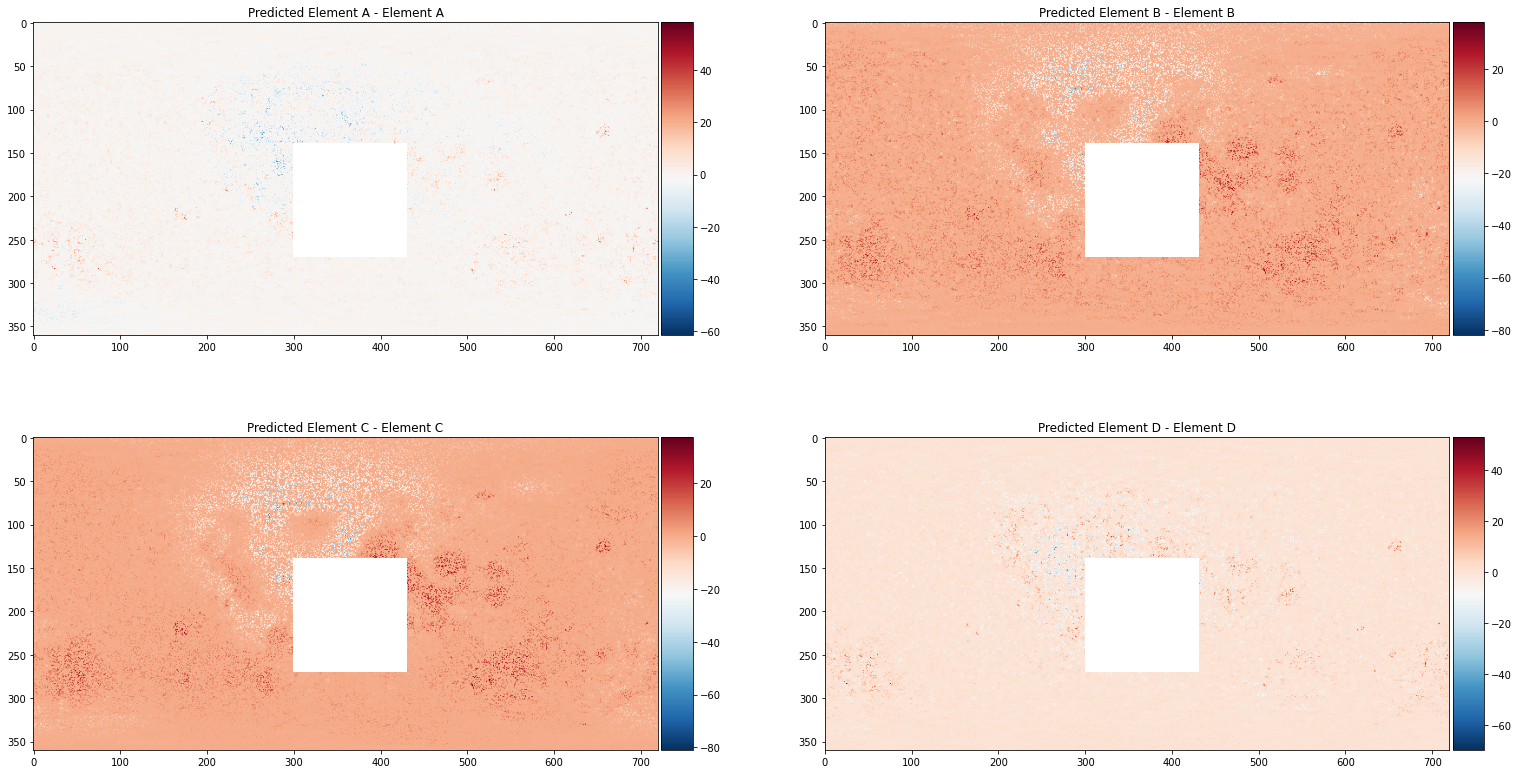

In [24]:
# Plot difference between prediction and true
difference_A = reconstructed_element_A - np.ma.MaskedArray(element_A_data, flat_mask)
difference_B = reconstructed_element_B - np.ma.MaskedArray(element_B_data, flat_mask)
difference_C = reconstructed_element_C - np.ma.MaskedArray(element_C_data, flat_mask)
difference_D = reconstructed_element_D - np.ma.MaskedArray(element_D_data, flat_mask)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(difference_A, cmap='RdBu_r')
axs[0, 0].set_title('Predicted Element A - Element A')
# Set Colorbars
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(difference_B, cmap='RdBu_r')
axs[0, 1].set_title('Predicted Element B - Element B')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(difference_C, cmap='RdBu_r')
axs[1, 0].set_title('Predicted Element C - Element C')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(difference_D, cmap='RdBu_r')
axs[1, 1].set_title('Predicted Element D - Element D')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()